In [ ]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib.colors as mcolors

In [ ]:
df = pd.read_csv('Sales.csv')
df.head()

,TransactionID,CustomerID,TransactionDate,ProductID,ProductCategory,Quantity,PricePerUnit,TotalAmount,TrustPointsUsed,PaymentMethod,DiscountApplied
0,1,1002.0,08/08/24 22:00,2008,Grocery,1,10.0,10.0,20,Trust Points,5.0
1,2,NaN,07/08/24 1:00,2004,Home Decor,1,10.0,10.0,0,Credit Card,20.0
2,3,1004.0,02/08/24 19:00,2002,Grocery,3,30.0,90.0,0,Credit Card,25.0
3,2,1003.0,07/08/24 17:00,2001,Toys,2,30.0,60.0,50,NaN,20.0
4,5,1001.0,09/08/24 9:00,2008,Grocery,1,NaN,NaN,20,Trust Points,5.0


## Data Preprocessing

In [ ]:
# Convert TransactionDate to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce')

<ipython-input-49-2798a42d9903>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce')


# **Edge Cases:**

*   Missing CustomerID.
*   Negative values in Quantity, PricePerUnit, TotalAmount.
nan in PaymentMethod have been handled properly.




In [ ]:
# Handle missing CustomerID by removing rows or filling with a placeholder
df['CustomerID'].fillna('Unknown', inplace=True)

<ipython-input-50-2c55874f6112>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['CustomerID'].fillna('Unknown', inplace=True)


In [ ]:
# Remove rows with negative or invalid quantities, prices, or amounts
df = df[df['Quantity'] >= 0]
df = df[df['PricePerUnit'] >= 0]
df = df[df['TotalAmount'] >= 0]

In [ ]:
# Fill missing numeric fields with 0 or median as appropriate
df['PricePerUnit'].fillna(df['PricePerUnit'].median(), inplace=True)
df['TotalAmount'].fillna(df['TotalAmount'].median(), inplace=True)

# Data Validation

Validation Steps:


*   Check if the derived fields, like TotalAmount = Quantity * PricePerUnit, are accurate.
*   Range and Consistency Checks: Ensure no negative quantities or prices.

In [ ]:
df['CalculatedTotalAmount'] = df['Quantity'] * df['PricePerUnit']
df['TotalMatches'] = df['CalculatedTotalAmount'] == df['TotalAmount']
mismatched_totals = df[df['TotalMatches'] == False]
if mismatched_totals.empty:
    print("Validation Passed: TotalAmount matches Quantity * PricePerUnit.")
else:
    print("Validation Failed: There are mismatches in TotalAmount.")
    print(mismatched_totals[['TransactionID', 'Quantity', 'PricePerUnit', 'TotalAmount', 'CalculatedTotalAmount']])


Validation Passed: TotalAmount matches Quantity * PricePerUnit.


In [ ]:
invalid_values = df[(df['Quantity'] < 0) | (df['PricePerUnit'] < 0) | (df['TotalAmount'] < 0)]

if invalid_values.empty:
    print("Validation Passed: No negative or invalid values found in Quantity, PricePerUnit, or TotalAmount.")
else:
    print("Validation Failed: Negative or invalid values found.")
    print(invalid_values[['TransactionID', 'Quantity', 'PricePerUnit', 'TotalAmount']])

Validation Passed: No negative or invalid values found in Quantity, PricePerUnit, or TotalAmount.


# Data Intregrity points that ensured to be covered are:


*   Referential Integrity: Ensure CustomerID exists in the customer database and is not missing or incorrect.

*   Consistency: Validate that TotalAmount, Quantity, and TrustPointsUsed are accurate and free of negative values.

*   Completeness: Check for missing values in critical columns and ensure all records have valid PaymentMethod.
*   Accuracy: Confirm TotalAmount is correctly calculated as Quantity * PricePerUnit before aggregation.





# Data Aggregation in python

**Fields to Aggregate:**

**TotalAmount:** Sum, average, or count based on CustomerID, ProductCategory, or TransactionDate.

**Quantity:** Sum or average based on ProductCategory or CustomerID.

**TrustPointsUsed:** Sum to understand how many points customers have used.

**Aggregation Types:**

**Sum:** Useful for TotalAmount and Quantity to get overall totals.

**Average:** Gives insights into typical purchase amounts.

**Count:** Useful to understand the number of transactions per customer or category.

Group the data by CustomerID and ProductCategory, then sum the TotalAmount, Quantity, and TrustPointsUsed for each group, and reset the index to obtain a clean DataFrame.

In [ ]:
grouped_df = df.groupby(['CustomerID', 'ProductCategory']).agg({
    'TotalAmount': 'sum',
    'Quantity': 'sum',
    'TrustPointsUsed': 'sum'
}).reset_index()

In [ ]:
grouped_df['CustomerID'] = pd.to_numeric(grouped_df['CustomerID'], errors='coerce').fillna(0)

# Convert CustomerID and TotalAmount to integers
grouped_df['CustomerID'] = grouped_df['CustomerID'].astype(int)
grouped_df['TotalAmount'] = grouped_df['TotalAmount'].astype(int)
grouped_df

,CustomerID,ProductCategory,TotalAmount,Quantity,TrustPointsUsed
0,1001,Electronics,170,7,220
1,1001,Home Decor,500,1,50
2,1001,Toys,170,6,0
3,1002,Electronics,30,1,0
4,1002,Fashion,50,1,20
5,1002,Grocery,10,1,20
6,1002,Toys,350,5,10
7,1003,Electronics,650,4,200
8,1003,Grocery,200,2,20
9,1003,Home Decor,1500,3,100


# Data Visulization

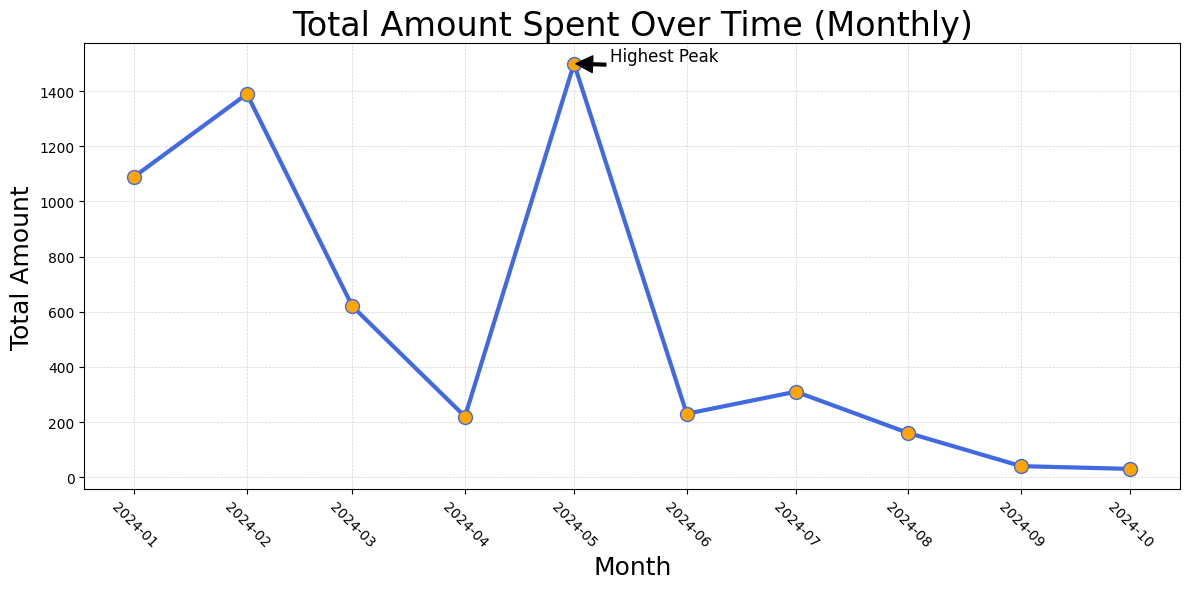

In [ ]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Group by month and sum the 'TotalAmount'
df['Month'] = df['TransactionDate'].dt.to_period('M')
monthly_sales = df.groupby('Month')['TotalAmount'].sum().reset_index()

# Convert 'Month' back to datetime format for plotting
monthly_sales['Month'] = monthly_sales['Month'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Month'], monthly_sales['TotalAmount'],
         marker='o', color='royalblue', linewidth=3, markersize=10, markerfacecolor='orange')


plt.title('Total Amount Spent Over Time (Monthly)', fontsize=24)
plt.xlabel('Month', fontsize=18)
plt.ylabel('Total Amount', fontsize=18)
plt.xticks(rotation=-45)
plt.grid(True, which='both', color='lightgray', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('white')

max_value = monthly_sales['TotalAmount'].max()
max_month = monthly_sales[monthly_sales['TotalAmount'] == max_value]['Month'].values[0]
plt.annotate('Highest Peak',
             xy=(max_month, max_value),
             xytext=(max_month + pd.Timedelta(days=10), max_value + 10),
             arrowprops=dict(facecolor='black', shrink=0.05, width=2),
             fontsize=12, color='black',
             ha='left')
plt.tight_layout()
plt.show()

<ipython-input-134-ae779a6c8083>:16: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



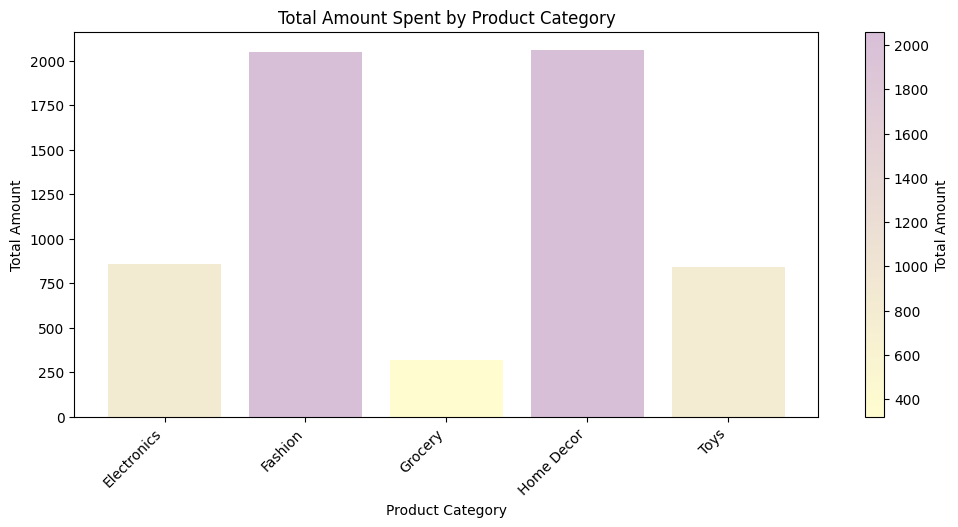

In [ ]:
# Group by 'ProductCategory' and sum the 'TotalAmount'
category_sales = grouped_df.groupby('ProductCategory')['TotalAmount'].sum().reset_index()

cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["#FFFDD0", "#D8BFD8"])
norm = plt.Normalize(category_sales['TotalAmount'].min(), category_sales['TotalAmount'].max())
colors = cmap(norm(category_sales['TotalAmount']))
plt.figure(figsize=(12, 5))
bars = plt.bar(category_sales['ProductCategory'], category_sales['TotalAmount'], color=colors)

plt.xlabel('Product Category')
plt.ylabel('Total Amount')
plt.title('Total Amount Spent by Product Category')
plt.xticks(rotation=45, ha='right')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Total Amount')

plt.show()

<ipython-input-135-66e67f4f99c7>:17: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



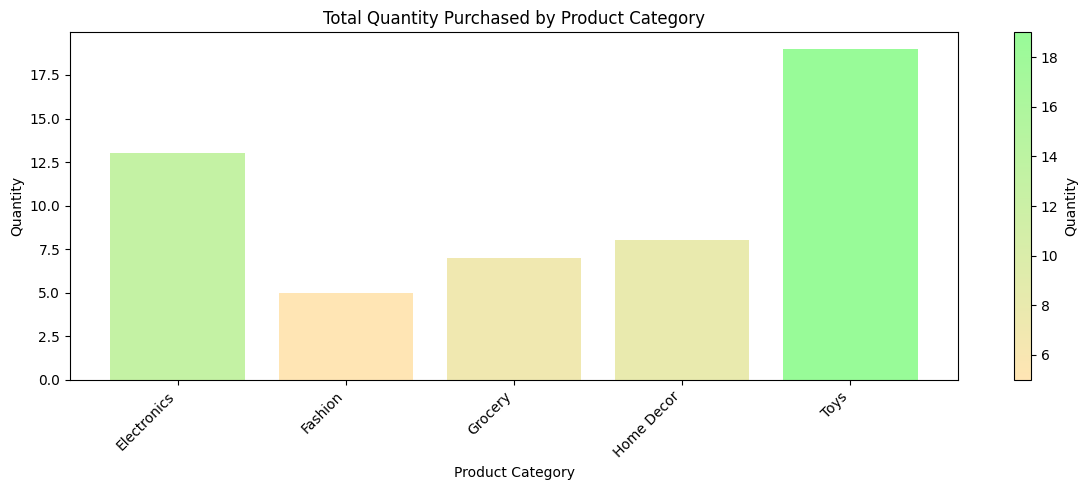

In [ ]:
# Group by 'ProductCategory' and sum the 'Quantity'
category_quantity = grouped_df.groupby('ProductCategory')['Quantity'].sum().reset_index()

cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["#FFE5B4", "#98FB98"])
norm = plt.Normalize(category_quantity['Quantity'].min(), category_quantity['Quantity'].max())
colors = cmap(norm(category_quantity['Quantity']))


plt.figure(figsize=(12, 5))
bars = plt.bar(category_quantity['ProductCategory'], category_quantity['Quantity'], color=colors)
plt.xlabel('Product Category')
plt.ylabel('Quantity')
plt.title('Total Quantity Purchased by Product Category')
plt.xticks(rotation=45, ha='right')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Quantity')
plt.tight_layout()
plt.show()

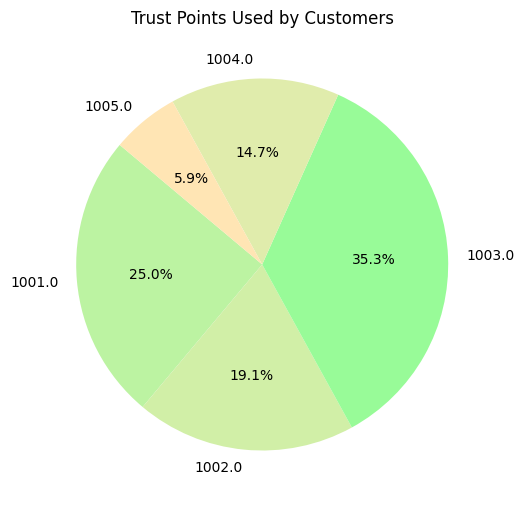

In [ ]:
customer_trust_points = df.groupby('CustomerID')['TrustPointsUsed'].sum().reset_index()
cmap = mcolors.LinearSegmentedColormap.from_list("gradient", ["#FFE5B4", "#98FB98"])

norm = plt.Normalize(customer_trust_points['TrustPointsUsed'].min(), customer_trust_points['TrustPointsUsed'].max())
colors = cmap(norm(customer_trust_points['TrustPointsUsed']))
plt.figure(figsize=(6, 12))
plt.pie(customer_trust_points['TrustPointsUsed'], labels=customer_trust_points['CustomerID'],
        autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Trust Points Used by Customers')

plt.show()

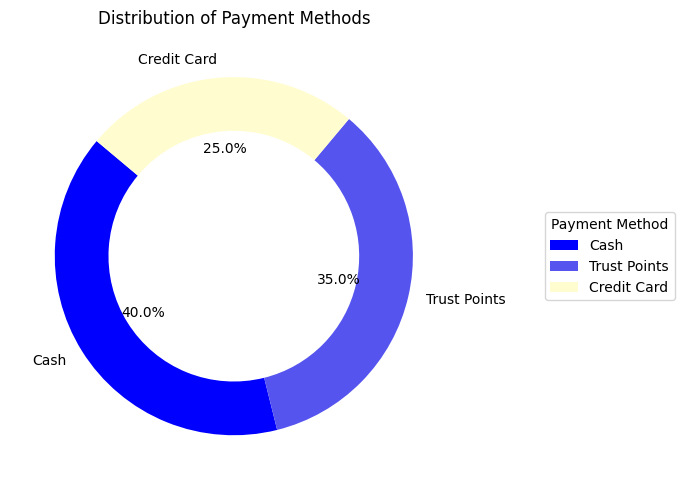

In [ ]:
payment_methods = df['PaymentMethod'].value_counts().reset_index()
payment_methods.columns = ['PaymentMethod', 'Count']
cmap = mcolors.LinearSegmentedColormap.from_list("gradient", ["#FFFDD0", "#0000FF"])
norm = plt.Normalize(payment_methods['Count'].min(), payment_methods['Count'].max())
colors = cmap(norm(payment_methods['Count']))
plt.figure(figsize=(8, 5))
wedges, texts, autotexts = plt.pie(payment_methods['Count'],
                                   labels=payment_methods['PaymentMethod'],
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=140,
                                   wedgeprops=dict(width=0.3))

plt.title('Distribution of Payment Methods')
plt.legend(wedges, payment_methods['PaymentMethod'], title="Payment Method", loc="center right", bbox_to_anchor=(1, 0, 0.5, 1))
plt.tight_layout()
plt.show()

# Checking for linearly projected data


Correlation Coefficient: Calculates Pearson's correlation to measure linearity.

**A value close to +1 or -1 indicates a strong linear relationship.**

In [ ]:
corr, _ = pearsonr(df['Quantity'], df['TotalAmount'])
print(f'Pearson Correlation Coefficient: {corr:.2f}')

Pearson Correlation Coefficient: 0.32


Performed linear regression and check the slope value. A significant slope and an R2 value close to 1 suggest linear projection.

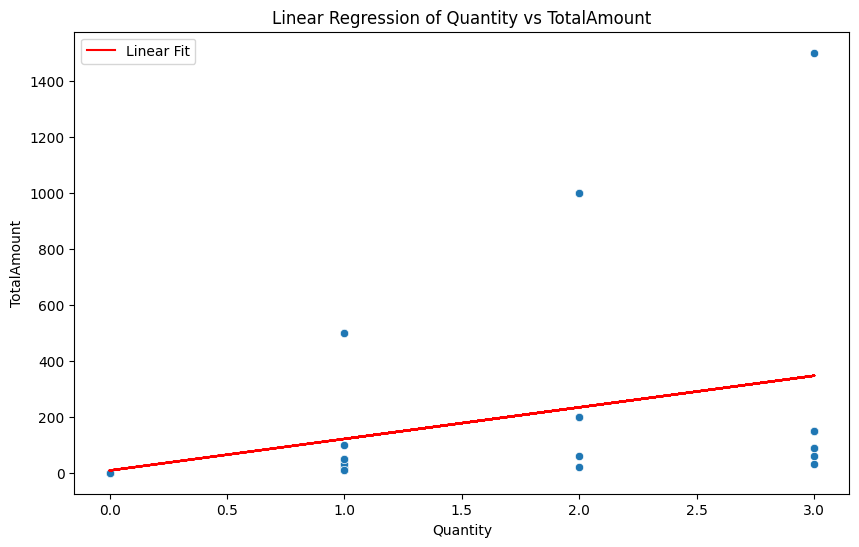

In [ ]:
X = df[['Quantity']]
y = df['TotalAmount']
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quantity', y='TotalAmount', data=df)
plt.plot(df['Quantity'], y_pred, color='red', label='Linear Fit')
plt.title('Linear Regression of Quantity vs TotalAmount')
plt.xlabel('Quantity')
plt.ylabel('TotalAmount')
plt.legend()
plt.show()

**Residual Analysis:** Analyze the residuals from the linear regression. If the residuals are randomly distributed without patterns, it confirms linearity.

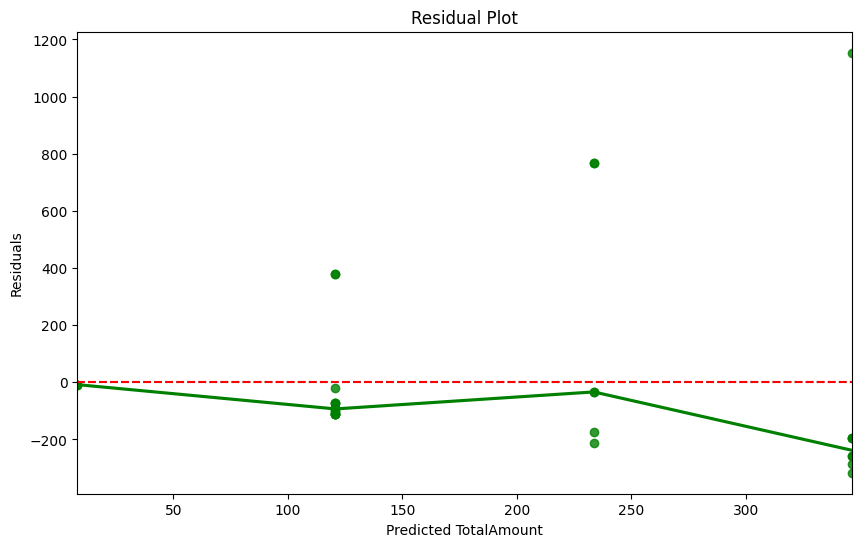

In [ ]:
residuals = y - y_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, color='g')
plt.title('Residual Plot')
plt.xlabel('Predicted TotalAmount')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.show()